In [1]:
import math
import os
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

from diffusers.optimization import get_scheduler
from google.cloud import storage

from model import FontDiffuserModel, FontDiffuserModelDPM, FontDiffuserDPMPipeline
from build import build_unet, build_style_encoder, build_content_encoder, build_ddpm_scheduler
from args import SampleArgs
from utils import x0_from_epsilon, reNormalize_img, normalize_mean_std, save_model, load_model

pygame 2.5.2 (SDL 2.28.2, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
args = SampleArgs()
unet = build_unet(args=args)
style_encoder = build_style_encoder(args=args)
content_encoder = build_content_encoder(args=args)
noise_scheduler = build_ddpm_scheduler(args)
storage_client = storage.Client(args.bucket_name)
bucket = storage_client.bucket(args.bucket_name)

Load the down block  DownBlock2D
Load the down block  MCADownBlock2D
The style_attention cross attention dim in Down Block 1 layer is 1024
The style_attention cross attention dim in Down Block 2 layer is 1024
Load the down block  MCADownBlock2D
The style_attention cross attention dim in Down Block 1 layer is 1024
The style_attention cross attention dim in Down Block 2 layer is 1024
Load the down block  DownBlock2D
Load the up block  UpBlock2D
Load the up block  StyleRSIUpBlock2D
Load the up block  StyleRSIUpBlock2D
Load the up block  UpBlock2D
Param count for Ds initialized parameters: 20591296
Get CG-GAN Style Encoder!
Param count for Ds initialized parameters: 1187008
Get CG-GAN Content Encoder!


In [3]:
content_encoder.load_state_dict(load_model(bucket, args.content_encoder_path))
style_encoder.load_state_dict(load_model(bucket, args.style_encoder_path))
unet.load_state_dict(load_model(bucket, args.unet_path))

model = FontDiffuserModelDPM(
    unet=unet,
    style_encoder=style_encoder,
    content_encoder=content_encoder)

model = model.cuda()

train_scheduler = build_ddpm_scheduler(args=args)

pipe = FontDiffuserDPMPipeline(
        model=model,
        ddpm_train_scheduler=train_scheduler,
        model_type=args.model_type,
        guidance_type=args.guidance_type,
        guidance_scale=args.guidance_scale,
    )

In [12]:
from PIL import Image

def get_normal_transform(resolution):
    normal_transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    return normal_transform

In [13]:
cfd = "/home/jupyter/ai_font/data/exp0820/processed/train_whole/시스템굴림"
sfd = "/home/jupyter/ai_font/data/exp0820/processed/train_assembled/플레이브밤비"
savefd = "/home/jupyter/ai_font/data/exp0820/report/zero/플레이브밤비"

In [14]:
letters = [f[-5] for f in os.listdir(sfd) if f.endswith(".png")]
transforms = get_normal_transform(96)

In [22]:
len(letters)

7290

In [ ]:
os.makedirs(savefd, exist_ok=True)
for letter in tqdm(letters):
    content_image = transforms(Image.open(f"{cfd}/시스템굴림__closing__{letter}.png").convert("RGB"))
    style_image = transforms(Image.open(f"{sfd}/플레이브밤비__closing__{letter}.png").convert("RGB"))
    content_image = content_image.unsqueeze(0).cuda()
    style_image = style_image.unsqueeze(0).cuda()

    images = pipe.generate(
        content_images=content_image,
        style_images=style_image,
        batch_size=content_image.shape[0],
        order=args.order,
        num_inference_step=args.num_inference_steps,
        content_encoder_downsample_size=args.content_encoder_downsample_size,
        t_start=args.t_start,
        t_end=args.t_end,
        dm_size=args.content_image_size,
        algorithm_type=args.algorithm_type,
        skip_type=args.skip_type,
        method=args.method,
        correcting_x0_fn=args.correcting_x0_fn)
    images[0].save(f"{savefd}/플레이브밤비__zero__{letter}.png")

  0%|          | 0/7290 [00:00<?, ?it/s]

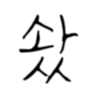

In [27]:
images[0]